In [ ]:
# default_exp camera_project

# camera_project

> A toolset for rosbag created by arg lab.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#|export
#nbdev_comment from __future__ import print_function

import os
import argparse
import cv2
import rosbag
import yaml
import time
import apriltag
import pytransform3d.rotations as pr
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists
from sensor_msgs.msg import Image
plt.rcParams['figure.figsize'] = (40, 40)        # large images

In [ ]:
cd data

/home/arg/arg_ros_tools/data


In [ ]:
calibration_file = 'camera_info.yaml'

with open(calibration_file, "r") as stream:
  try:
    dictionary = yaml.safe_load(stream)
    camera_matrix_dict = dictionary.get("camera_matrix")
    im_w = dictionary.get("image_width")
    im_h = dictionary.get("image_height")
    dist_coeffs_dict = dictionary.get("distortion_coefficients")
    dist_model = dictionary.get("distortion_model")
  except yaml.YAMLError as exc:
    print(exc)
#print(camera_matrix_dict)
#print("Image Width: {}, Height: {}".format(im_w, im_h))
#print(dist_coeffs_dict)
#print(dist_model)
cam_matrix = np.array(camera_matrix_dict["data"]).reshape(3, 3)
dist_coeffs = np.array(dist_coeffs_dict["data"])
print(cam_matrix)
print(dist_coeffs)

[[333.7593689    0.         323.96972656]
 [  0.         333.7593689  178.44508362]
 [  0.           0.           1.        ]]
[0. 0. 0. 0. 0.]


id: 1, center: [593.06479121 564.86750745]
id: 2, center: [535.48083824 534.91575232]
id: 201, center: [527.90555698 576.73744185]
id: 202, center: [552.12100946 558.04305022]
id: 203, center: [599.47762394 539.83293869]
id: 204, center: [571.55414734 525.64828262]
[INFO] 6 total AprilTags detected


Text(0.5, 1.0, 'Filter')

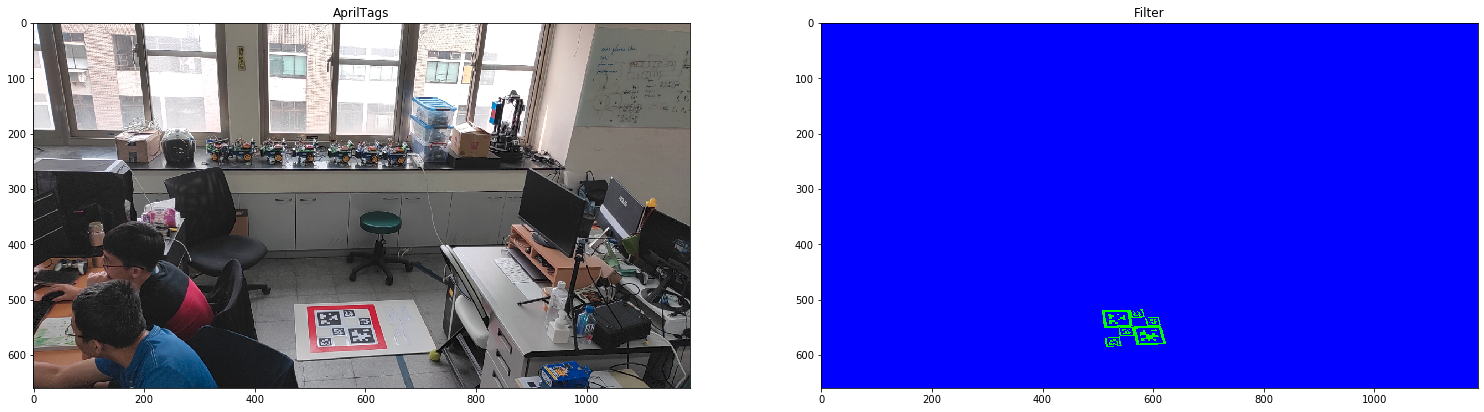

In [ ]:
img_path = 'tag.png'
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
dst = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
options = apriltag.DetectorOptions(families="tag36h11")
detector = apriltag.Detector(options)
results = detector.detect(gray)
detection_results, dimg = detector.detect(gray, return_image=True)
for r in results:
    print("id: {}, center: {}".format(r.tag_id, r.center))
print("[INFO] {} total AprilTags detected".format(len(results)))
plt.subplot(132),plt.imshow(dst, cmap = 'brg')
plt.title('AprilTags')
detection_results, dimg = detector.detect(gray, return_image=True)
plt.subplot(133),plt.imshow(dimg, cmap = 'brg')
plt.title('Filter')

Text(0.5, 1.0, 'Big_corner for multi apriltag')

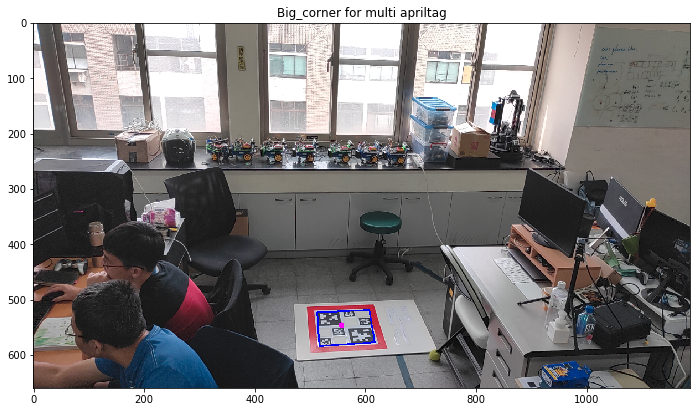

In [ ]:
#get the big apriltag with 6 small apriltags
for r in results:
    # extract the bounding box (x, y)-coordinates for the AprilTag
    # and convert each of the (x, y)-coordinate pairs to integers
    (ptA, ptB, ptC, ptD) = r.corners
    ptA = (int(ptA[0]), int(ptA[1]))
    ptB = (int(ptB[0]), int(ptB[1]))
    ptC = (int(ptC[0]), int(ptC[1]))
    ptD = (int(ptD[0]), int(ptD[1]))
    #get the corner point for big apriltag
    tag_id = str(r.tag_id)
    if tag_id == '201':
        big_ptA = ptA
    if tag_id == '2':
        big_ptB = ptB
        # draw the center (x, y)-coordinates of the AprilTag
        cv2.circle(dst, ptD, 5, (255, 0, 255), -1)
    if tag_id == '203':
        big_ptC_1 = ptC
    if tag_id == '204':
        big_ptC_2 = ptC
    if tag_id == '1':
        big_ptD = ptD
ptC_List = list(big_ptC_1)
ptC_List[1] = big_ptC_2[1]
big_ptC = tuple(ptC_List)

# draw the bounding box of the AprilTag detection
color = (0, 0, 255)
cv2.line(dst, big_ptA, big_ptB, color, 2)
cv2.line(dst, big_ptB, big_ptC, color, 2)
cv2.line(dst, big_ptC, big_ptD, color, 2)
cv2.line(dst, big_ptD, big_ptA, color, 2)

plt.subplot(133),plt.imshow(dst, cmap = 'brg')
plt.title('Big_corner for multi apriltag')

In [ ]:
tag_size = 0.4
s = 0.5 * tag_size

#print(results[0].corners)
img_pts = results[0].corners
img_pts[0][0] = big_ptA[0]
img_pts[0][1] = big_ptA[1]
img_pts[1][0] = big_ptB[0]
img_pts[1][1] = big_ptB[1]
img_pts[2][0] = big_ptC[0]
img_pts[2][1] = big_ptC[1]
img_pts[3][0] = big_ptD[0]
img_pts[3][1] = big_ptD[1]
#img_pts = big_pt.reshape(1,4,2) 

obj_pt1 = [-s, -s, 0.0]
obj_pt2 = [ s, -s, 0.0]
obj_pt3 = [ s,  s, 0.0]
obj_pt4 = [-s,  s, 0.0]
obj_pts = obj_pt1 + obj_pt2 + obj_pt3 + obj_pt4
obj_pts = np.array(obj_pts).reshape(4,3)

img_pts = img_pts.reshape(1,4,2) 
print(img_pts)
print(obj_pts)

_, r_vec, t_vec = cv2.solvePnP(obj_pts, img_pts, cam_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)

[[[517. 584.]
  [513. 523.]
  [607. 519.]
  [617. 577.]]]
[[-0.2 -0.2  0. ]
 [ 0.2 -0.2  0. ]
 [ 0.2  0.2  0. ]
 [-0.2  0.2  0. ]]


In [ ]:
R_mat, _ = cv2.Rodrigues(r_vec)
T = np.hstack((R_mat, t_vec)).reshape(3,4)
tag_pose = np.vstack((T, [0,0,0,1])).reshape(4,4)
dist = np.linalg.norm(t_vec)

print(R_mat)
print(t_vec)
print(tag_pose)
print(dist)

[[-0.25454476  0.96332867  0.08488135]
 [-0.93650436 -0.22366067 -0.27006572]
 [-0.24117743 -0.14823557  0.95909315]]
[[1.06248907]
 [1.66181765]
 [1.48563662]]
[[-0.25454476  0.96332867  0.08488135  1.06248907]
 [-0.93650436 -0.22366067 -0.27006572  1.66181765]
 [-0.24117743 -0.14823557  0.95909315  1.48563662]
 [ 0.          0.          0.          1.        ]]
2.4693394031263867


In [ ]:
s = 0.5 * tag_size
cuboid_pts = np.array([
                    -1, -1, 0,
                     1, -1, 0,
                     1,  1, 0,
                    -1,  1, 0,
                    -1, -1, -2*1,
                     1, -1, -2*1,
                     1,  1, -2*1,
                    -1,  1, -2*1,
            ]).reshape(-1, 1, 3) * s

#obj2_pts = obj_pts * 2
obj2_pts = obj_pts
H = 0.1
obj2_pts[0][2] = H
obj2_pts[1][2] = H
obj2_pts[2][2] = H
obj2_pts[3][2] = H

c_pts = np.array([
                  0, 0, 0,
                  0, 0, s * 4,
                  ]).reshape(2, 3)

proj_img_pts, jac = cv2.projectPoints(
    obj2_pts, r_vec, t_vec, cam_matrix, dist_coeffs)

proj_img_c_up, jac = cv2.projectPoints(
    c_pts, r_vec, t_vec, cam_matrix, dist_coeffs)

print(cuboid_pts)
print(obj2_pts)
print(c_pts)
print(proj_img_pts)
print(proj_img_c_up)

[[[-0.2 -0.2  0. ]]

 [[ 0.2 -0.2  0. ]]

 [[ 0.2  0.2  0. ]]

 [[-0.2  0.2  0. ]]

 [[-0.2 -0.2 -0.4]]

 [[ 0.2 -0.2 -0.4]]

 [[ 0.2  0.2 -0.4]]

 [[-0.2  0.2 -0.4]]]
[[-0.2 -0.2  0.1]
 [ 0.2 -0.2  0.1]
 [ 0.2  0.2  0.1]
 [-0.2  0.2  0.1]]
[[0.  0.  0. ]
 [0.  0.  0.8]]
[[[510.8629948  553.92175523]]

 [[500.65612472 497.10367887]]

 [[593.15320664 489.81153961]]

 [[598.16171631 549.17469217]]]
[[[562.66583593 551.78483718]]

 [[491.43289549 392.62913675]]]


[491.43289549 392.62913675]


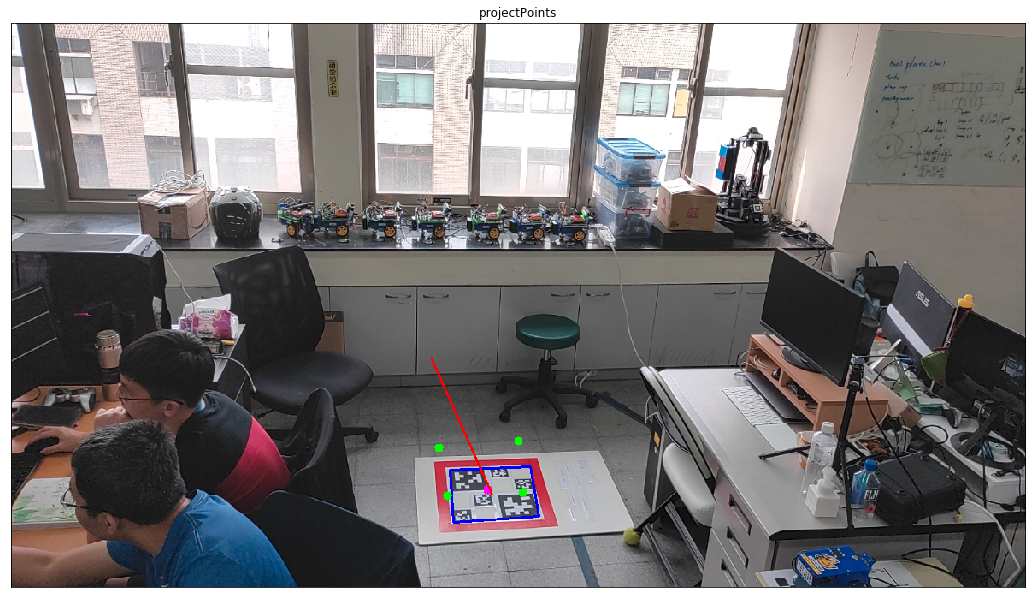

In [ ]:
# draw the projected points (x, y)-coordinates 
for im_pt in proj_img_pts:
  pt = im_pt[0]
  (p_x, p_y) = (int(pt[0]), int(pt[1]))
  cv2.circle(dst, (p_x, p_y), 5, (0, 255, 0), -1)

# draw line from center up along z axis
im_c = proj_img_c_up[0][0]
im_up = proj_img_c_up[1][0]
print(im_up)
(c_x, c_y) = (int(im_c[0]), int(im_c[1]))
(up_x, up_y) = (int(im_up[0]), int(im_up[1]))

cv2.line(dst, (c_x, c_y), (up_x, up_y), (255, 0, 0), 2)

plt.subplot(121),plt.imshow(dst, cmap = 'brg')
plt.title('projectPoints'), plt.xticks([]), plt.yticks([])

figsize = 15 # param larger is bigger, adjust as needed 
plt.rcParams['figure.figsize'] = (figsize, figsize)  
plt.show()

Text(0.5, 1.0, 'with block')

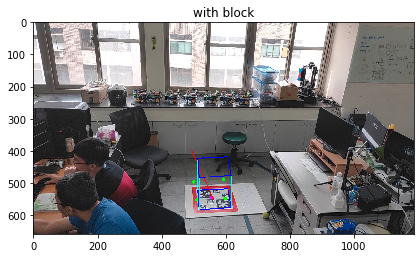

In [ ]:
# get up box
H = 100
ptA_List_up = list(big_ptA)
ptA_List_up[1] -= H
ptB_List_up = list(big_ptB)
ptB_List_up[1] -= H
ptC_List_up = list(big_ptC)
ptC_List_up[1] -= H
ptD_List_up = list(big_ptD)
ptD_List_up[1] -= H
# draw line from lower box to upper box
color = (0, 255, 255)
cv2.line(dst, big_ptA, tuple(ptA_List_up), color, 2)
cv2.line(dst, big_ptB, tuple(ptB_List_up), color, 2)
cv2.line(dst, big_ptC, tuple(ptC_List_up), color, 2)
cv2.line(dst, big_ptD, tuple(ptD_List_up), color, 2)
# draw upper box
color = (0, 0, 255)
cv2.line(dst, tuple(ptA_List_up), tuple(ptB_List_up), color, 2)
cv2.line(dst, tuple(ptB_List_up), tuple(ptC_List_up), color, 2)
cv2.line(dst, tuple(ptC_List_up), tuple(ptD_List_up), color, 2)
cv2.line(dst, tuple(ptD_List_up), tuple(ptA_List_up), color, 2)

plt.subplot(121),plt.imshow(dst, cmap = 'brg')
plt.title('with block')